<a id='intro'></a>
# Explore Dataset

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

## Image processing
# import skimage

# Data preprocessing
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split

# Modelling
import keras 
import keras.backend as K
from keras.callbacks import TensorBoard
from keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

# Transfer Learning
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16

# Model Evaluation
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import hamming_loss, label_ranking_loss, average_precision_score 

# Plotting & Data visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pre-configure Plotting Style 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
%config InlineBackend.figure_format = 'retina'

# Miscellaneous
import os
import time
import random
import itertools 
from tqdm import tqdm
from collections import Counter

## Read Dataset

In [2]:
# Load data set
train = pd.read_csv('train.csv')

In [3]:
# Check dimensionality of dataset
train.shape

(7242, 27)

In [4]:
# Preview data
train.head()

Id                                Genre  Action  Adventure  \
0  tt0086425                  ['Comedy', 'Drama']       0          0   
1  tt0085549        ['Drama', 'Romance', 'Music']       0          0   
2  tt0086465                           ['Comedy']       0          0   
3  tt0086567               ['Sci-Fi', 'Thriller']       0          0   
4  tt0086034  ['Action', 'Adventure', 'Thriller']       1          1   

   Animation  Biography  Comedy  Crime  Documentary  Drama  ...  N/A  News  \
0          0          0       1      0            0      1  ...    0     0   
1          0          0       0      0            0      1  ...    0     0   
2          0          0       1      0            0      0  ...    0     0   
3          0          0       0      0            0      0  ...    0     0   
4          0          0       0      0            0      0  ...    0     0   

   Reality-TV  Romance  Sci-Fi  Short  Sport  Thriller  War  Western  
0           0        0       0      0      0         0    0        0  
1           0        1       0      0      0         0    0        0  
2           0        0       0      0      0         0    0        0  
3           0        0       1      0      0         1    0        0  
4           0        0       0      0      0         1    0        0  

[5 rows x 27 columns]

In [5]:
# List Features
for i,v in enumerate(train):
    print(i, v)

0 Id
1 Genre
2 Action
3 Adventure
4 Animation
5 Biography
6 Comedy
7 Crime
8 Documentary
9 Drama
10 Family
11 Fantasy
12 History
13 Horror
14 Music
15 Musical
16 Mystery
17 N/A
18 News
19 Reality-TV
20 Romance
21 Sci-Fi
22 Short
23 Sport
24 Thriller
25 War
26 Western


In [6]:
print('Total number of genres: {}'.format(len(train.columns[2:])))
print('Total number of posters/images: {}'.format(train.Id.nunique()))
print('Total number of genre permutations: {}'.format(train.Genre.nunique()))

Total number of genres: 25
Total number of posters/images: 7231
Total number of genre permutations: 552


In [7]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
N/A               0
Reality-TV        0
dtype: object

## Data Cleaning

In [8]:
# Drop N/A rows
na_rows = train[train.Genre.str.contains('N/A') == True].index
train = train.drop(na_rows, axis=0)

# Reality-TV rows
rt_rows = train[train.Genre.str.contains('Reality-TV') == True].index
train = train.drop(rt_rows, axis=0)

In [9]:
# Drop N/A, Reality-TV columns
train.drop(columns=['N/A','Reality-TV'], inplace=True)

# Reset index
train.reset_index(drop=True, inplace=True)

**Dropped the following 13 rows (also removed on original datset):**

- `N/A`
    - 3304    tt0116748
    - 3312    tt0289456
    - 3531    tt0282965
    - 3783    tt0322650
    - 4029    tt0402398
    - 4635    tt0468580
    - 4870    tt2546300
    - 5174    tt2546294
    - 5175    tt2546294
    - 7192    tt3521442
  
  
- `Reality-TV`
    - 4544    tt0808142
    - 6870    tt2884170

In [10]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
dtype: object

### Convert Images to Array

In [11]:
# Read in images 
train_images = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('dataset/images/'+ train['Id'][i]+'.jpg', target_size=(250, 200, 3))
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

100%|█████████████████████████████████████████████████████████████████████████████| 7242/7242 [00:31<00:00, 230.34it/s]


### Display Movie Posters

Genre of Movie Poster 1: ['Romance'] 
Genre of Movie Poster 2: ['Comedy', 'Drama', 'Romance']


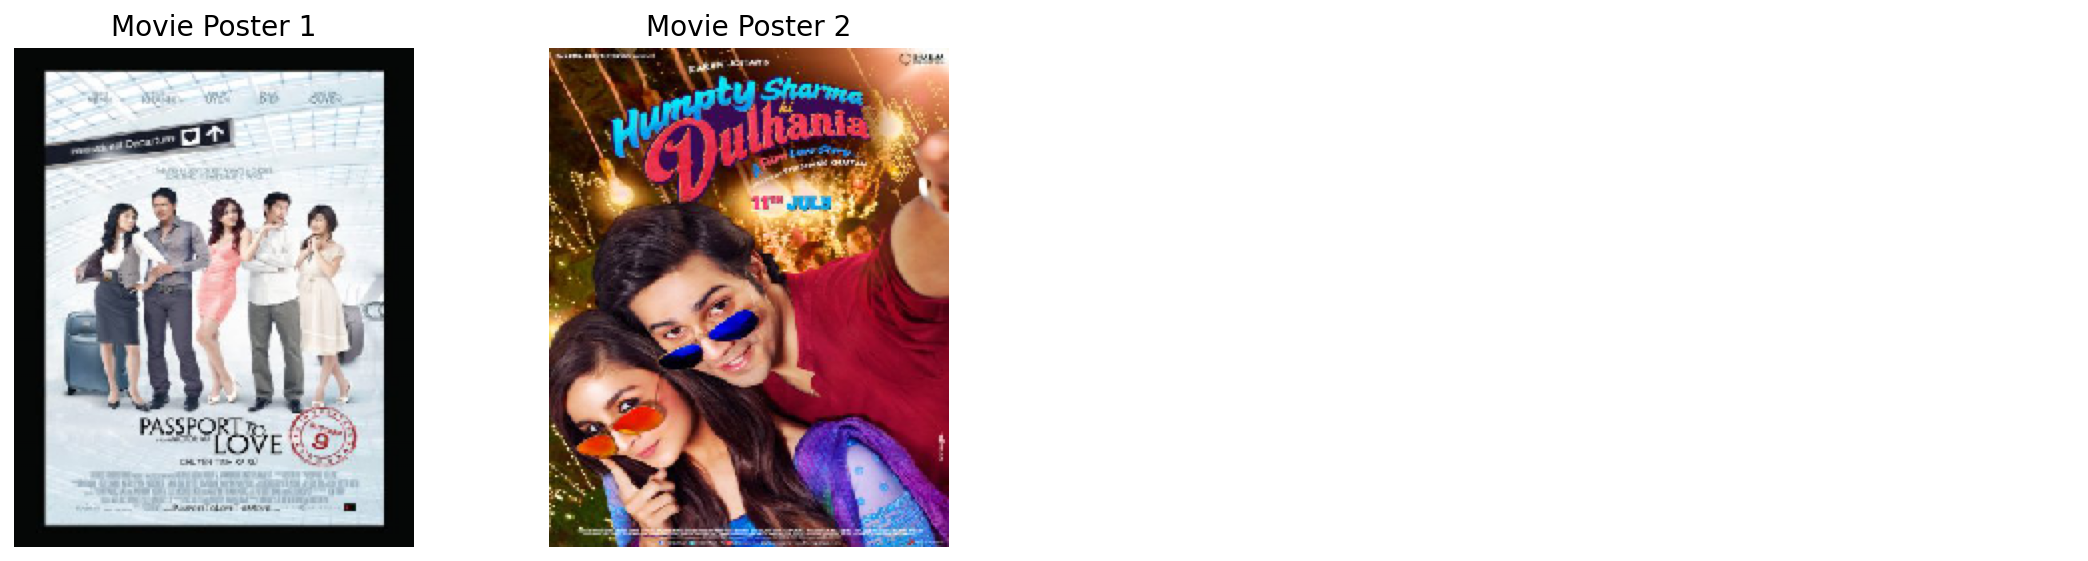

In [12]:
# Create a generator for random indexes
poster_index = list(range(7243))
rand_index = random.sample(poster_index, 2)

# Select random posters
poster_1, poster_2 = train_images[rand_index[0]], train_images[rand_index[1]]

# Display movie poster and title
fig, ax = plt.subplots(ncols = 4, figsize=(15, 4))
ax[0].imshow(poster_1)
ax[1].imshow(poster_2)
ax[0].set_title('Movie Poster 1', fontsize=14)
ax[1].set_title('Movie Poster 2', fontsize=14)

# Remove axes
for ax in ax:
    ax.axis('off')    
plt.tight_layout()

print('Genre of Movie Poster 1: {} \nGenre of Movie Poster 2: {}'.format(train['Genre'][rand_index[0]], train['Genre'][rand_index[1]]))

Sample of movie posters in the dataset

### Genre Counts

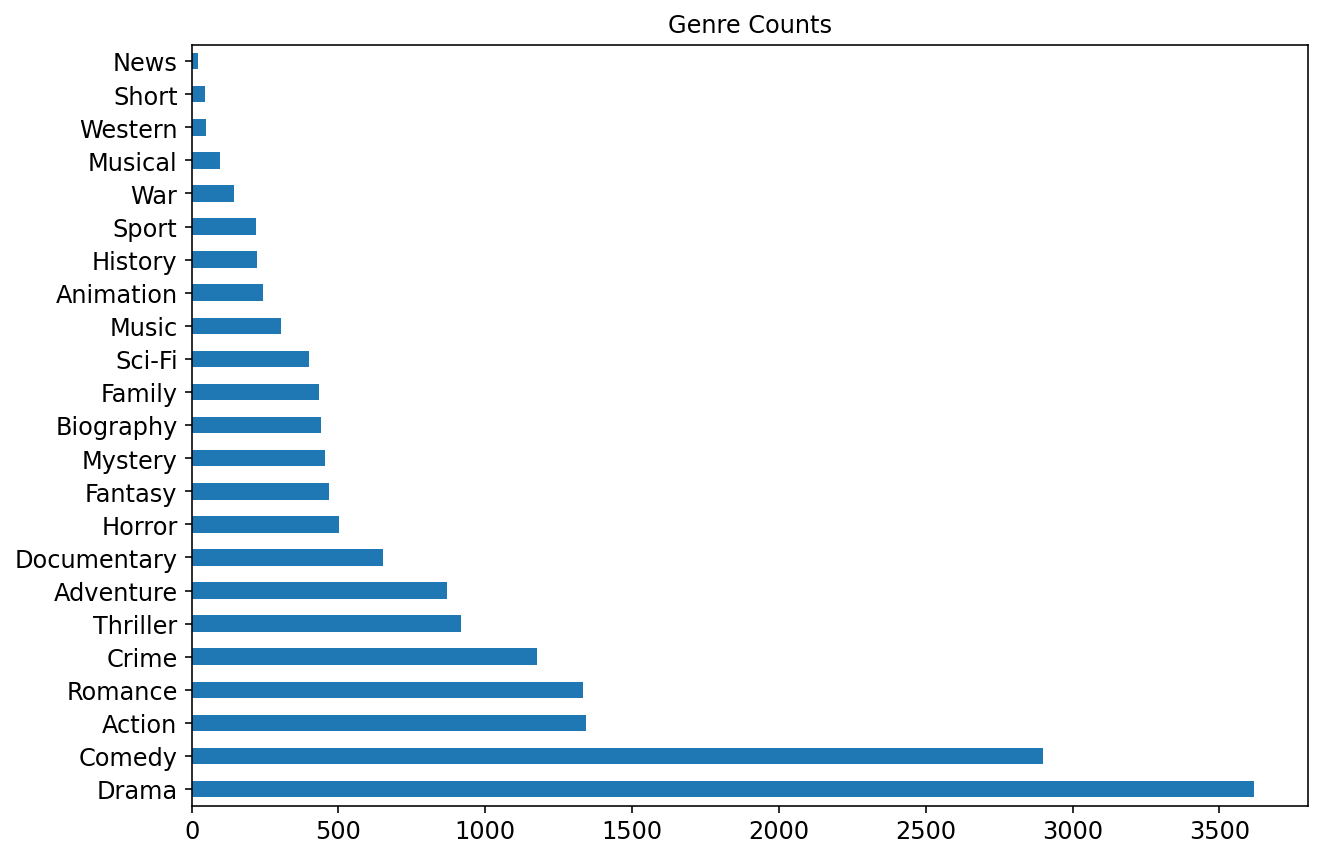

In [13]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False).plot(kind='barh', figsize=(10,7))
plt.title('Genre Counts');

We can see from this distribution of the movie poster data set that most movies have `Drama` as one of its labels. We foresee that our model might overfit on the `Drama` genre. This will affect every new image, since the model might predict the `Drama` genre even though in actuality is not.

### Mutli-label Counts

C:\Users\qwert\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


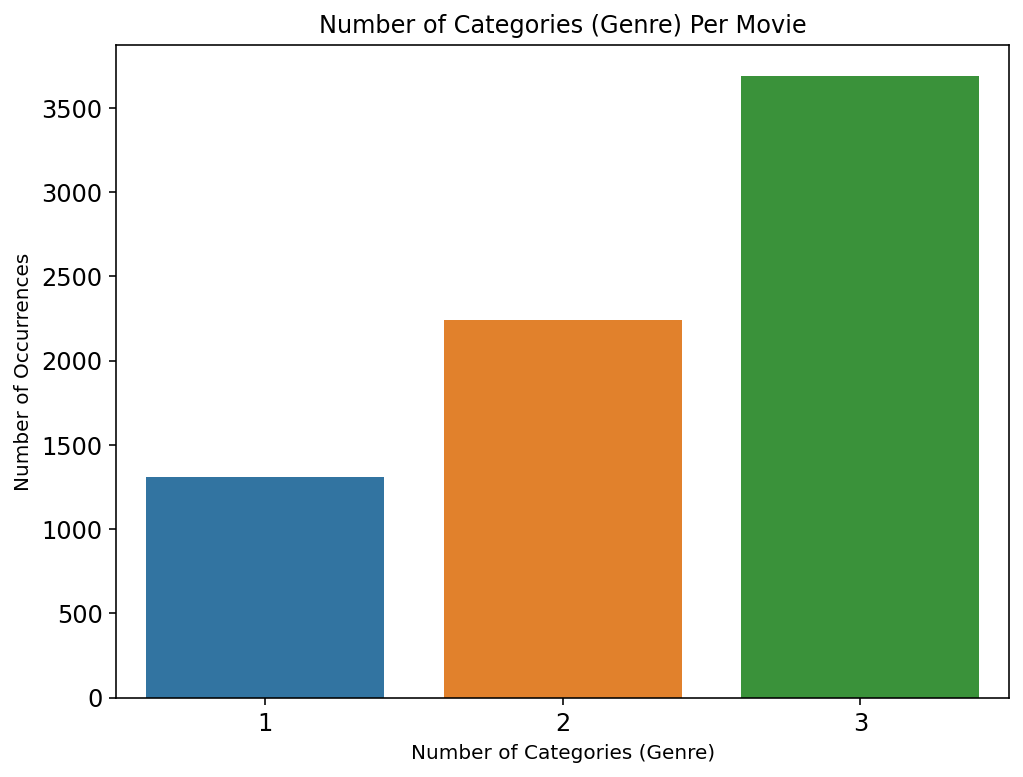

In [14]:
# Movies with multilabels
row_sum = train.iloc[:, 2:].sum(axis=1)
x = row_sum.value_counts()

# Plot barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(x.index, x.values)
plt.title("Number of Categories (Genre) Per Movie", fontsize=12)
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Categories (Genre)');

### Unique Multi-label Classifications

In [15]:
# Identify permutation of Genres that appear only once
df_unique = train[train['Genre'].map(train['Genre'].value_counts()) < 2]

In [16]:
# Permutations of Genres that appear only once
len(df_unique.Genre.unique().tolist())

193

<a id='preprocessing'></a>
# Date Preprocessing

## Set up X and y

In [17]:
X = np.array(train_images)
y = np.array(train.drop(columns=['Id', 'Genre']))

## Train/Test Split (with Iterative Stratification)

In [18]:
# mskf = MultilabelStratifiedKFold(n_splits=2, random_state=42)

# for train_index, test_index in mskf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

## Train/Test Split

In [19]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =0.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5793, 250, 200, 3), (1449, 250, 200, 3), (5793, 23), (1449, 23))

**Have to fix this:**
*The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2*

**To rectify this:**
Use ``from skmultilearn.model_selection import iterative_train_test_split`` for a more balanced split for multi-label problems or ``from iterstrat.ml_stratifiers import MultilabelStratifiedKFold`` for itertaive stratification

## VGG16 Model

In [22]:
# Create the base pre-trained model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 200, 3))

# Add a global spatial average pooling layer
x = vgg_model.output

# Adaptive Pooling
x = GlobalAveragePooling2D()(x) 

# Add fully-connected layers
x = Dense(64, activation='relu')(x)

# Add final fully-connected layer
predictions = Dense(23, activation='sigmoid')(x)

# this is the model we will train
vgg_model = Model(inputs=vgg_model.input, outputs=predictions)
len(vgg_model.layers)

22

In [24]:
# Using Adam optimser with a learning rate of 0.01
optimizer = Adam(lr=0.01)

# Compile the model (should be done *after* setting layers to non-trainable)
vgg_model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Train model
vgg_history = vgg_model.fit(X_train, y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=15)

Epoch 1/15
182/182 [==============================] - 1688s 9s/step - loss: 0.2748 - accuracy: 0.1977 - val_loss: 0.2672 - val_accuracy: 0.1919
Epoch 2/15
182/182 [==============================] - 1670s 9s/step - loss: 0.2685 - accuracy: 0.2163 - val_loss: 0.2669 - val_accuracy: 0.1919
Epoch 3/15
182/182 [==============================] - 1682s 9s/step - loss: 0.2661 - accuracy: 0.1891 - val_loss: 0.2661 - val_accuracy: 0.1919
Epoch 4/15
182/182 [==============================] - 1691s 9s/step - loss: 0.2651 - accuracy: 0.1957 - val_loss: 0.2660 - val_accuracy: 0.1919
Epoch 5/15
182/182 [==============================] - 1707s 9s/step - loss: 0.2657 - accuracy: 0.2009 - val_loss: 0.2658 - val_accuracy: 0.1919
Epoch 6/15
182/182 [==============================] - 9628s 53s/step - loss: 0.2628 - accuracy: 0.1887 - val_loss: 0.2659 - val_accuracy: 0.1919
Epoch 7/15
182/182 [==============================] - 1665s 9s/step - loss: 0.2643 - accuracy: 0.1952 - val_loss: 0.2666 - val_accuracy

In [25]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 50, 128)       0     

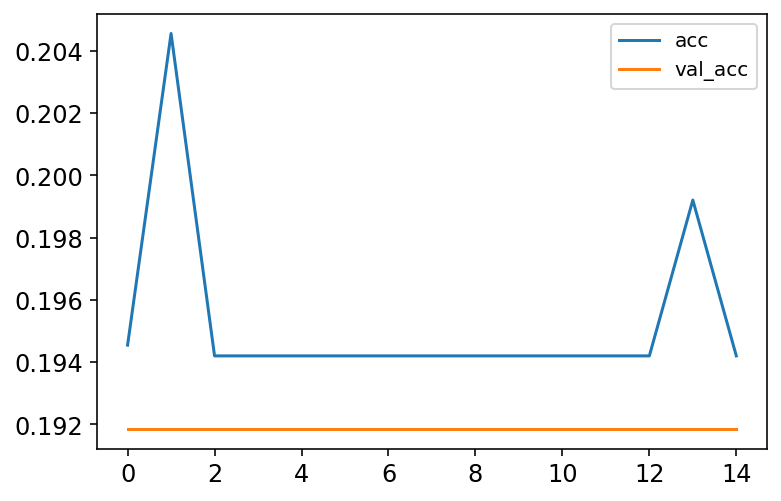

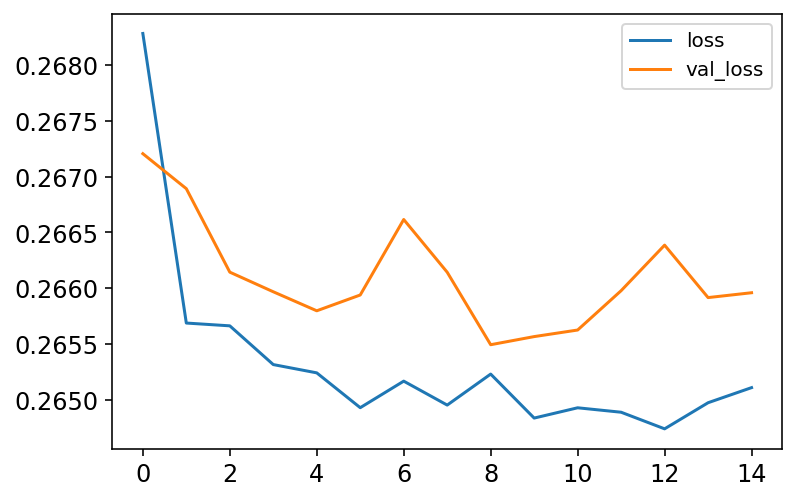

Mean Training Accuracy:  0.195 
Mean Testing Accuracy:  0.192
Mean Training Loss:  0.265 
Mean Testing Loss:  0.266


In [74]:
#Accuracy
plt.plot(vgg_history.history['accuracy'],label='acc')
plt.plot(vgg_history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()
#Loss
plt.plot(vgg_history.history['loss'],label='loss')
plt.plot(vgg_history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

print('Mean Training Accuracy: ', round(np.mean(vgg_history.history['accuracy']), 3), '\nMean Testing Accuracy: ', round(np.mean(vgg_history.history['val_accuracy']), 3))
print('Mean Training Loss: ', round(np.mean(vgg_history.history['loss']), 3), '\nMean Testing Loss: ', round(np.mean(vgg_history.history['val_loss']), 3))

In general, the reason for this low accuracy is the small number of epochs.

<a id='predict'></a>
# Predictions on Test & Unseen Images

## VGG16 Model Predictions on Test Images

In [39]:
def prediction(img_filepath, target_size=(250, 200, 3)):
    new_img = image.load_img(img_filepath, target_size=target_size)
    new_img = image.img_to_array(new_img) / 255
    
    classes = np.array(train.columns[2:])
    proba = vgg_model.predict(new_img.reshape(1,250,200,3))
    top_4 = np.argsort(proba[0])[:-5:-1]
    
    print('Genre Predictions:')
    for i in range(4):
        print('{}'.format(classes[top_4[i]])+' ({:.3})'.format(proba[0][top_4[i]]))
    plt.axis('off')
    plt.imshow(new_img)

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


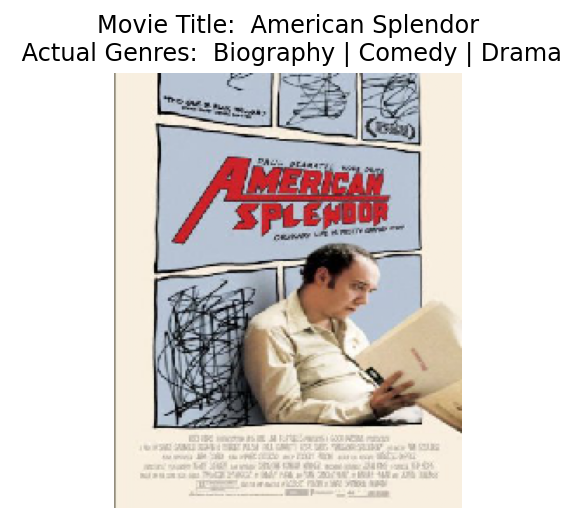

In [40]:
test_img = image.array_to_img(X_test[150])
plt.imshow(test_img)
plt.title('Movie Title:  American Splendor\n Actual Genres:  Biography | Comedy | Drama');
plt.axis('off')

prediction('dataset/images/tt0305206.jpg')

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


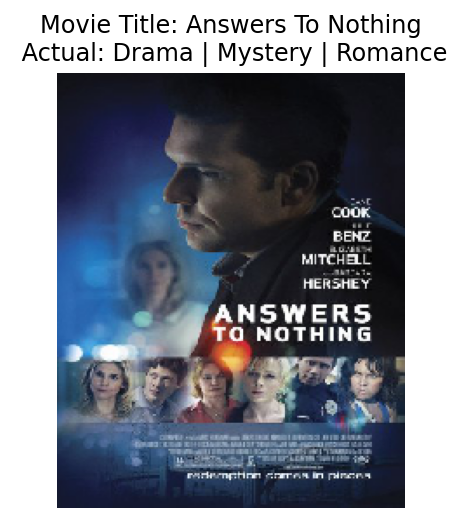

In [41]:
test_img_2 = image.array_to_img(X_test[555])
plt.imshow(test_img_2)
plt.axis('off')
plt.title('Movie Title: Answers To Nothing\n Actual: Drama | Mystery | Romance');
prediction('dataset/images/tt1523939.jpg')

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


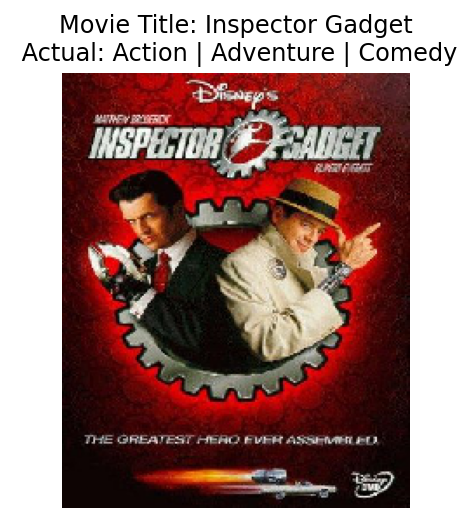

In [42]:
test_img_3 = image.array_to_img(X_test[800])
plt.imshow(test_img_3)
plt.axis('off')
plt.title('Movie Title: Inspector Gadget\n Actual: Action | Adventure | Comedy')
prediction('dataset/images/tt0141369.jpg')

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


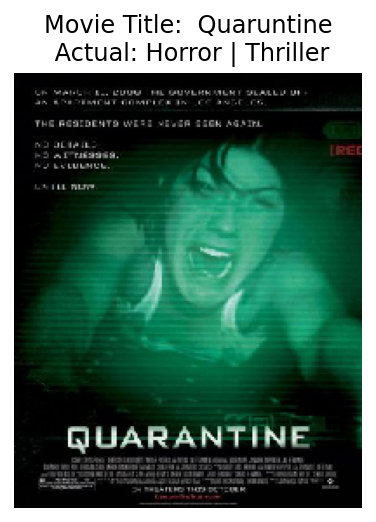

In [43]:
test_img_4 = image.array_to_img(X_test[1400])
plt.imshow(test_img_4)
plt.axis('off')
plt.title('Movie Title:  Quaruntine\n Actual: Horror | Thriller')
prediction('dataset/images/tt1082868.jpg')

## VGG16 Model Predictions on Unseen Images

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


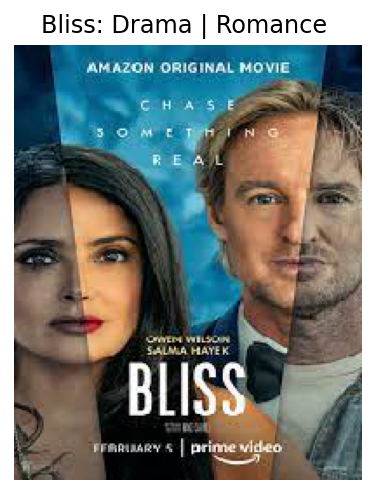

In [44]:
prediction('dataset/test_new/1.jpg')
plt.title('Bliss: Drama | Romance ');

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


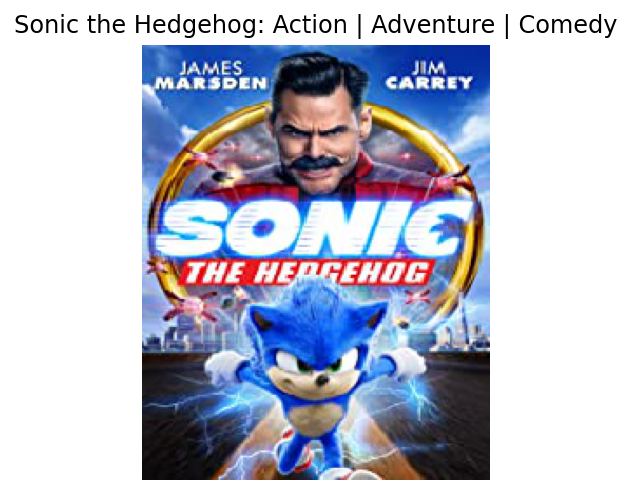

In [72]:
prediction('dataset/test_new/2.jpg')
plt.title('Sonic the Hedgehog: Action | Adventure | Comedy');

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


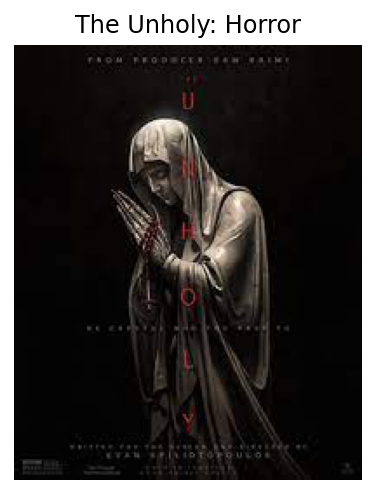

In [46]:
prediction('dataset/test_new/3.jpg')
plt.title('The Unholy: Horror');

Genre Predictions:
Drama (0.518)
Comedy (0.342)
Action (0.196)
Crime (0.177)


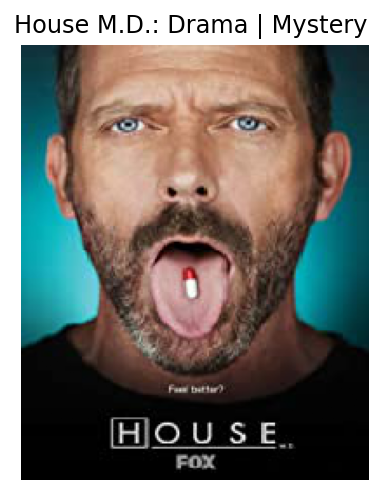

In [48]:
prediction('dataset/test_new/5.jpg')
plt.title('House M.D.: Drama | Mystery ');

## Multi-label Confusion Matrix

In [49]:
preds = vgg_model.predict(X_test)
preds = preds.argmax(axis=-1)

In [50]:
test_labels = y_test.argmax(axis=-1)

In [51]:
matrix = multilabel_confusion_matrix(test_labels, preds)
print(matrix)

[[[1179    0]
  [ 270    0]]

 [[1343    0]
  [ 106    0]]

 [[1432    0]
  [  17    0]]

 [[1371    0]
  [  78    0]]

 [[ 994    0]
  [ 455    0]]

 [[1360    0]
  [  89    0]]

 [[1352    0]
  [  97    0]]

 [[   0 1171]
  [   0  278]]

 [[1447    0]
  [   2    0]]

 [[1440    0]
  [   9    0]]

 [[1448    0]
  [   1    0]]

 [[1417    0]
  [  32    0]]

 [[1448    0]
  [   1    0]]

 [[1447    0]
  [   2    0]]

 [[1447    0]
  [   2    0]]

 [[1448    0]
  [   1    0]]

 [[1447    0]
  [   2    0]]

 [[1443    0]
  [   6    0]]

 [[1448    0]
  [   1    0]]]


In [52]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       270
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        78
           4       0.00      0.00      0.00       455
           5       0.00      0.00      0.00        89
           6       0.00      0.00      0.00        97
           7       0.19      1.00      0.32       278
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        32
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          20       0.00    

C:\Users\qwert\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hamming Loss


In [53]:
h_loss = hamming_loss(test_labels, preds)
print('Hamming Loss: {}'.format(round(h_loss, 3)))

Hamming Loss: 0.808


## Average Precision Score


In [55]:
y_pred_proba = vgg_model.predict(X_test)
ap_score = average_precision_score(y_test, y_pred_proba)
print('Avg. Precision Score: {}'.format(round(ap_score, 3)))

Avg. Precision Score: 0.102


## Ranking Loss


In [56]:
#y_pred_proba = model.predict(X_test)
ranking_loss = label_ranking_loss(y_test, y_pred_proba)
print('Ranking Loss: {}'.format(round(ranking_loss, 3)))

Ranking Loss: 0.184


# IMDb Analysis

In [75]:
movies = pd.read_csv('IMDb_movies.csv')
ratings = pd.read_csv('IMDb_ratings.csv')
rat_col = ratings.columns.to_list()
ratings = ratings[rat_col[:5]+rat_col[-4:]]
movies = movies.merge(ratings,on='imdb_title_id')

C:\Users\qwert\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [76]:
movies.head()

imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year date_published                      genre  duration           country  \
0  1894     1894-10-09                    Romance        45               USA   
1  1906     1906-12-26    Biography, Crime, Drama        70         Australia   
2  1911     1911-08-19                      Drama        53  Germany, Denmark   
3  1912     1912-11-13             Drama, History       100               USA   
4  1911     1911-03-06  Adventure, Drama, Fantasy        68             Italy   

  language                             director  ... reviews_from_users  \
0     None                      Alexander Black  ...                1.0   
1     None                         Charles Tait  ...                7.0   
2      NaN                            Urban Gad  ...                5.0   
3  English                   Charles L. Gaskill  ...               25.0   
4  Italian  Francesco Bertolini, Adolfo Padovan  ...               31.0   

  reviews_from_critics weighted_average_vote total_votes  mean_vote  \
0                  2.0                   5.9         154        5.9   
1                  7.0                   6.1         589        6.3   
2                  2.0                   5.8         188        6.0   
3                  3.0                   5.2         446        5.3   
4                 14.0                   7.0        2237        6.9   

   median_vote us_voters_rating us_voters_votes non_us_voters_rating  \
0          6.0              6.4            51.0                  6.0   
1          6.0              6.0            96.0                  6.2   
2          6.0              6.2            31.0                  5.9   
3          5.0              5.5           207.0                  4.7   
4          7.0              7.0           488.0                  7.0   

   non_us_voters_votes  
0                 70.0  
1                331.0  
2                123.0  
3                105.0  
4               1166.0  

[5 rows x 30 columns]

In [77]:
ratings.head()

imdb_title_id  weighted_average_vote  total_votes  mean_vote  median_vote  \
0     tt0000009                    5.9          154        5.9          6.0   
1     tt0000574                    6.1          589        6.3          6.0   
2     tt0001892                    5.8          188        6.0          6.0   
3     tt0002101                    5.2          446        5.3          5.0   
4     tt0002130                    7.0         2237        6.9          7.0   

   us_voters_rating  us_voters_votes  non_us_voters_rating  \
0               6.4             51.0                   6.0   
1               6.0             96.0                   6.2   
2               6.2             31.0                   5.9   
3               5.5            207.0                   4.7   
4               7.0            488.0                   7.0   

   non_us_voters_votes  
0                 70.0  
1                331.0  
2                123.0  
3                105.0  
4               1166.0

In [78]:
movies.year.unique()

array([1894, 1906, 1911, 1912, 1919, 1913, 1914, 1915, 1916, 1917, 1918,
       1920, 1921, 1924, 1922, 1923, 1925, 1926, 1935, 1927, 1928, 1983,
       1929, 1930, 1932, 1931, 1937, 1938, 1933, 1934, 1936, 1940, 1939,
       1942, 1943, 1941, 1948, 1944, 2001, 1946, 1945, 1947, 1973, 1949,
       1950, 1952, 1951, 1962, 1953, 1954, 1955, 1961, 1956, 1958, 1957,
       1959, 1960, 1963, 1965, 1971, 1964, 1966, 1968, 1967, 1969, 1976,
       1970, 1979, 1972, 1981, 1978, 2000, 1989, 1975, 1974, 1986, 1990,
       2018, 1977, 1982, 1980, 1993, 1984, 1985, 1988, 1987, 2005, 1991,
       2002, 1994, 1992, 1995, 2017, 1997, 1996, 2006, 1999, 1998, 2007,
       2008, 2003, 2004, 2010, 2009, 2011, 2013, 2012, 2016, 2015, 2014,
       2019, 2020, '2012', '2015', '2009', '2013', '2018', '2014', '2017',
       '2011', '2016', '1981', '1975', '2010', '1984', '2007', '2006',
       '2001', '2004', '1979', '2019', '1967', '1978', '2003', '2005',
       '1969', '1990', '1983', '2002', '1996', '2008'

In [79]:
movies = movies[movies.year != 'TV Movie 2019']
movies.year = movies.year.astype({'year':'int32'},copy = False)
movies = movies[movies.year < 2020]

In [81]:
# Binning time intervals
def binning(num, divisor):
    return num - (num%divisor)

# Transforming multiple languagues into 1 language. First language is picked because main language seems to be the first one of the list.
def split_lang(row):
    return row.split(',')[0]

#Frequency: year, 5_year, Decades
#Metric: votes, avg_vote, no_of_films
def lang_graph(df,freq,metric,dim):
    fig, axes = plt.subplots(1,2)
    axes[0].set_title('{} per {} across {}s'.format(metric.capitalize(), freq.capitalize(), dim.capitalize()),fontsize=24)
    axes[0].set_xlabel('{}s'.format(metric.capitalize()),fontsize=18)
    axes[1].set_title('{} per {} (Exc. English) across {}'.format(metric.capitalize(),freq.capitalize(), dim.capitalize()),fontsize=24)
    df = df.groupby(by=[dim,freq]).agg(
        no_of_films = (dim,'count'),
        avg_vote = ('avg_vote','mean'),
        votes = ('votes','sum')
    ).reset_index()
    sns.lineplot(ax=axes[0],y=df[metric],x=df[freq],hue=df[dim])
    df = df[df[dim]!='English']
    sns.lineplot(ax=axes[1],y=df[metric],x=df[freq],hue=df[dim])
    
def top_genres(df,dim):
    top_genres = pd.DataFrame()
    
    for i in df[dim].unique().tolist():       
        top_genres[i] = df.genre[df[dim]==i].head(10).tolist()
    return top_genres

base = 10
movies['Decade'] = movies.year.apply(binning, divisor=base)
base = 5
movies['5_year'] = movies.year.apply(binning, divisor=base)

In [82]:
new_column_list = list(movies.columns[0:4])+list(movies.columns[-2:])+list(movies.columns[4:-2])
movies = movies.reindex(columns=new_column_list)
movies.head()

imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year  Decade  5_year date_published                      genre  duration  \
0  1894    1890    1890     1894-10-09                    Romance        45   
1  1906    1900    1905     1906-12-26    Biography, Crime, Drama        70   
2  1911    1910    1910     1911-08-19                      Drama        53   
3  1912    1910    1910     1912-11-13             Drama, History       100   
4  1911    1910    1910     1911-03-06  Adventure, Drama, Fantasy        68   

            country  ... reviews_from_users reviews_from_critics  \
0               USA  ...                1.0                  2.0   
1         Australia  ...                7.0                  7.0   
2  Germany, Denmark  ...                5.0                  2.0   
3               USA  ...               25.0                  3.0   
4             Italy  ...               31.0                 14.0   

  weighted_average_vote total_votes mean_vote median_vote  us_voters_rating  \
0                   5.9         154       5.9         6.0               6.4   
1                   6.1         589       6.3         6.0               6.0   
2                   5.8         188       6.0         6.0               6.2   
3                   5.2         446       5.3         5.0               5.5   
4                   7.0        2237       6.9         7.0               7.0   

   us_voters_votes non_us_voters_rating non_us_voters_votes  
0             51.0                  6.0                70.0  
1             96.0                  6.2               331.0  
2             31.0                  5.9               123.0  
3            207.0                  4.7               105.0  
4            488.0                  7.0              1166.0  

[5 rows x 32 columns]

In [83]:
L = movies.language.groupby(movies.language).count().sort_values(ascending=False).to_frame()
L.head(10)

language
language                  
English              35581
French                3886
Japanese              2815
Spanish               2806
Italian               2717
Hindi                 2062
German                1749
Turkish               1345
Russian               1336
English, Spanish      1105

In [84]:
movies.country.value_counts()

USA                                           28234
India                                          5924
UK                                             4068
Japan                                          3067
France                                         3040
                                              ...  
Mexico, Canada, Netherlands                       1
France, Afghanistan                               1
Venezuela, Spain, Canada, Cuba                    1
France, Belgium, Luxembourg, Côte d'Ivoire        1
Austria, Luxembourg, Germany, UK                  1
Name: country, Length: 4874, dtype: int64

In [85]:
df_movies = movies[['imdb_title_id','year','Decade','5_year','genre','language','votes','us_voters_votes','non_us_voters_votes','avg_vote','us_voters_rating','non_us_voters_rating']][(movies.language.notna())].copy()
df_movies = df_movies[df_movies.language!='None'].reset_index(drop=True)
df_movies.rename(columns={'us_voters_rating':'avg_vote_us'
                          ,'non_us_voters_rating':'avg_vote_non_us'
                         ,'us_voters_votes':'votes_us',
                         'non_us_voters_votes':'votes_non_us'},inplace=True)
#processing language
df_movies.language = df_movies.language.apply(split_lang)
df_movies.year = df_movies.year.astype('int')
df_movies.head()

imdb_title_id  year  Decade  5_year                      genre language  \
0     tt0002101  1912    1910    1910             Drama, History  English   
1     tt0002130  1911    1910    1910  Adventure, Drama, Fantasy  Italian   
2     tt0002199  1912    1910    1910           Biography, Drama  English   
3     tt0002423  1919    1910    1915  Biography, Drama, Romance   German   
4     tt0002445  1913    1910    1910             Drama, History  Italian   

   votes  votes_us  votes_non_us  avg_vote  avg_vote_us  avg_vote_non_us  
0    446     207.0         105.0       5.2          5.5              4.7  
1   2237     488.0        1166.0       7.0          7.0              7.0  
2    484     173.0         181.0       5.7          5.9              5.6  
3    753     139.0         455.0       6.8          6.6              6.8  
4    273      40.0         154.0       6.2          5.8              6.2

In [86]:
movies[(movies.duration<30) | (movies.votes<100)]

imdb_title_id                        title               original_title  \
42836     tt0344485  Toutes ces belles promesses  Toutes ces belles promesses   
65224     tt2188220                      Töchter                      Töchter   
79882     tt6185026        The Baylock Residence        The Baylock Residence   
79933     tt6201302                   Santa Fake                   Santa Fake   
81474     tt6910380           My Name Is Myeisha           My Name Is Myeisha   

       year  Decade  5_year date_published           genre  duration  \
42836  2003    2000    2000     2003-08-01  Drama, Romance        85   
65224  2014    2010    2010     2014-09-11           Drama        84   
79882  2019    2010    2015     2019-09-17        Thriller        90   
79933  2019    2010    2015     2019-10-04          Family        86   
81474  2018    2010    2015     2018-01-21           Drama        82   

               country  ... reviews_from_users reviews_from_critics  \
42836  France, Belgium  ...                3.0                  3.0   
65224          Germany  ...                1.0                  7.0   
79882               UK  ...                4.0                  6.0   
79933              USA  ...                6.0                  2.0   
81474              USA  ...                1.0                  8.0   

      weighted_average_vote total_votes mean_vote median_vote  \
42836                   6.6          99       6.6         6.0   
65224                   5.8          99       5.8         6.0   
79882                   3.7          99       3.7         3.0   
79933                   5.4          99       5.4         5.0   
81474                   5.5          99       5.5         6.0   

       us_voters_rating  us_voters_votes non_us_voters_rating  \
42836               7.3             12.0                  6.5   
65224               4.5              8.0                  5.5   
79882               3.6             27.0                  2.7   
79933               5.2             27.0                  4.5   
81474               5.3             33.0                  4.8   

      non_us_voters_votes  
42836                60.0  
65224                65.0  
79882                39.0  
79933                46.0  
81474                29.0  

[5 rows x 32 columns]

In [87]:
top_lang = df_movies.language.groupby(df_movies.language).size().sort_values(ascending=False)[:10]
top_lang = top_lang.index
print(top_lang)
df_movies = df_movies[df_movies.language.isin(top_lang)].reset_index(drop=True)
df_movies.head()

Index(['English', 'French', 'Spanish', 'Italian', 'Japanese', 'Hindi',
       'German', 'Russian', 'Turkish', 'Mandarin'],
      dtype='object', name='language')


imdb_title_id  year  Decade  5_year                      genre language  \
0     tt0002101  1912    1910    1910             Drama, History  English   
1     tt0002130  1911    1910    1910  Adventure, Drama, Fantasy  Italian   
2     tt0002199  1912    1910    1910           Biography, Drama  English   
3     tt0002423  1919    1910    1915  Biography, Drama, Romance   German   
4     tt0002445  1913    1910    1910             Drama, History  Italian   

   votes  votes_us  votes_non_us  avg_vote  avg_vote_us  avg_vote_non_us  
0    446     207.0         105.0       5.2          5.5              4.7  
1   2237     488.0        1166.0       7.0          7.0              7.0  
2    484     173.0         181.0       5.7          5.9              5.6  
3    753     139.0         455.0       6.8          6.6              6.8  
4    273      40.0         154.0       6.2          5.8              6.2

In [88]:
df_movies.genre.unique().tolist()[:5]

['Drama, History',
 'Adventure, Drama, Fantasy',
 'Biography, Drama',
 'Biography, Drama, Romance',
 'Drama']

In [90]:
top10_genre = df_movies.groupby(by='genre').agg(No_of_films=('language','count')).sort_values(by='No_of_films',ascending=False)[:10]
top10_genre = top10_genre.index
top10_genre

Index(['Drama', 'Comedy', 'Comedy, Drama', 'Drama, Romance', 'Horror',
       'Comedy, Romance', 'Comedy, Drama, Romance', 'Horror, Thriller',
       'Crime, Drama', 'Action, Crime, Drama'],
      dtype='object', name='genre')

In [91]:
df_gen = df_movies[df_movies['genre'].isin(top10_genre)].reset_index(drop=True)
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28869 entries, 0 to 28868
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_title_id    28869 non-null  object 
 1   year             28869 non-null  int32  
 2   Decade           28869 non-null  int64  
 3   5_year           28869 non-null  int64  
 4   genre            28869 non-null  object 
 5   language         28869 non-null  object 
 6   votes            28869 non-null  int64  
 7   votes_us         28809 non-null  float64
 8   votes_non_us     28868 non-null  float64
 9   avg_vote         28869 non-null  float64
 10  avg_vote_us      28809 non-null  float64
 11  avg_vote_non_us  28868 non-null  float64
dtypes: float64(5), int32(1), int64(3), object(3)
memory usage: 2.5+ MB


In [92]:
df_gen = df_gen.groupby(by=['genre','year','5_year','Decade']).agg(
        no_of_films = ('genre','count'),
        avg_vote = ('avg_vote','mean'),
        votes = ('votes','sum')
    ).reset_index()
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   genre        944 non-null    object 
 1   year         944 non-null    int64  
 2   5_year       944 non-null    int64  
 3   Decade       944 non-null    int64  
 4   no_of_films  944 non-null    int64  
 5   avg_vote     944 non-null    float64
 6   votes        944 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 51.8+ KB


In [93]:
df_gen.head()

genre  year  5_year  Decade  no_of_films  avg_vote  votes
0  Action, Crime, Drama  1929    1925    1920            1       7.2    520
1  Action, Crime, Drama  1930    1930    1930            3       5.6    519
2  Action, Crime, Drama  1931    1930    1930            1       7.3  11746
3  Action, Crime, Drama  1932    1930    1930            3       6.9  25419
4  Action, Crime, Drama  1933    1930    1930            4       6.1    978

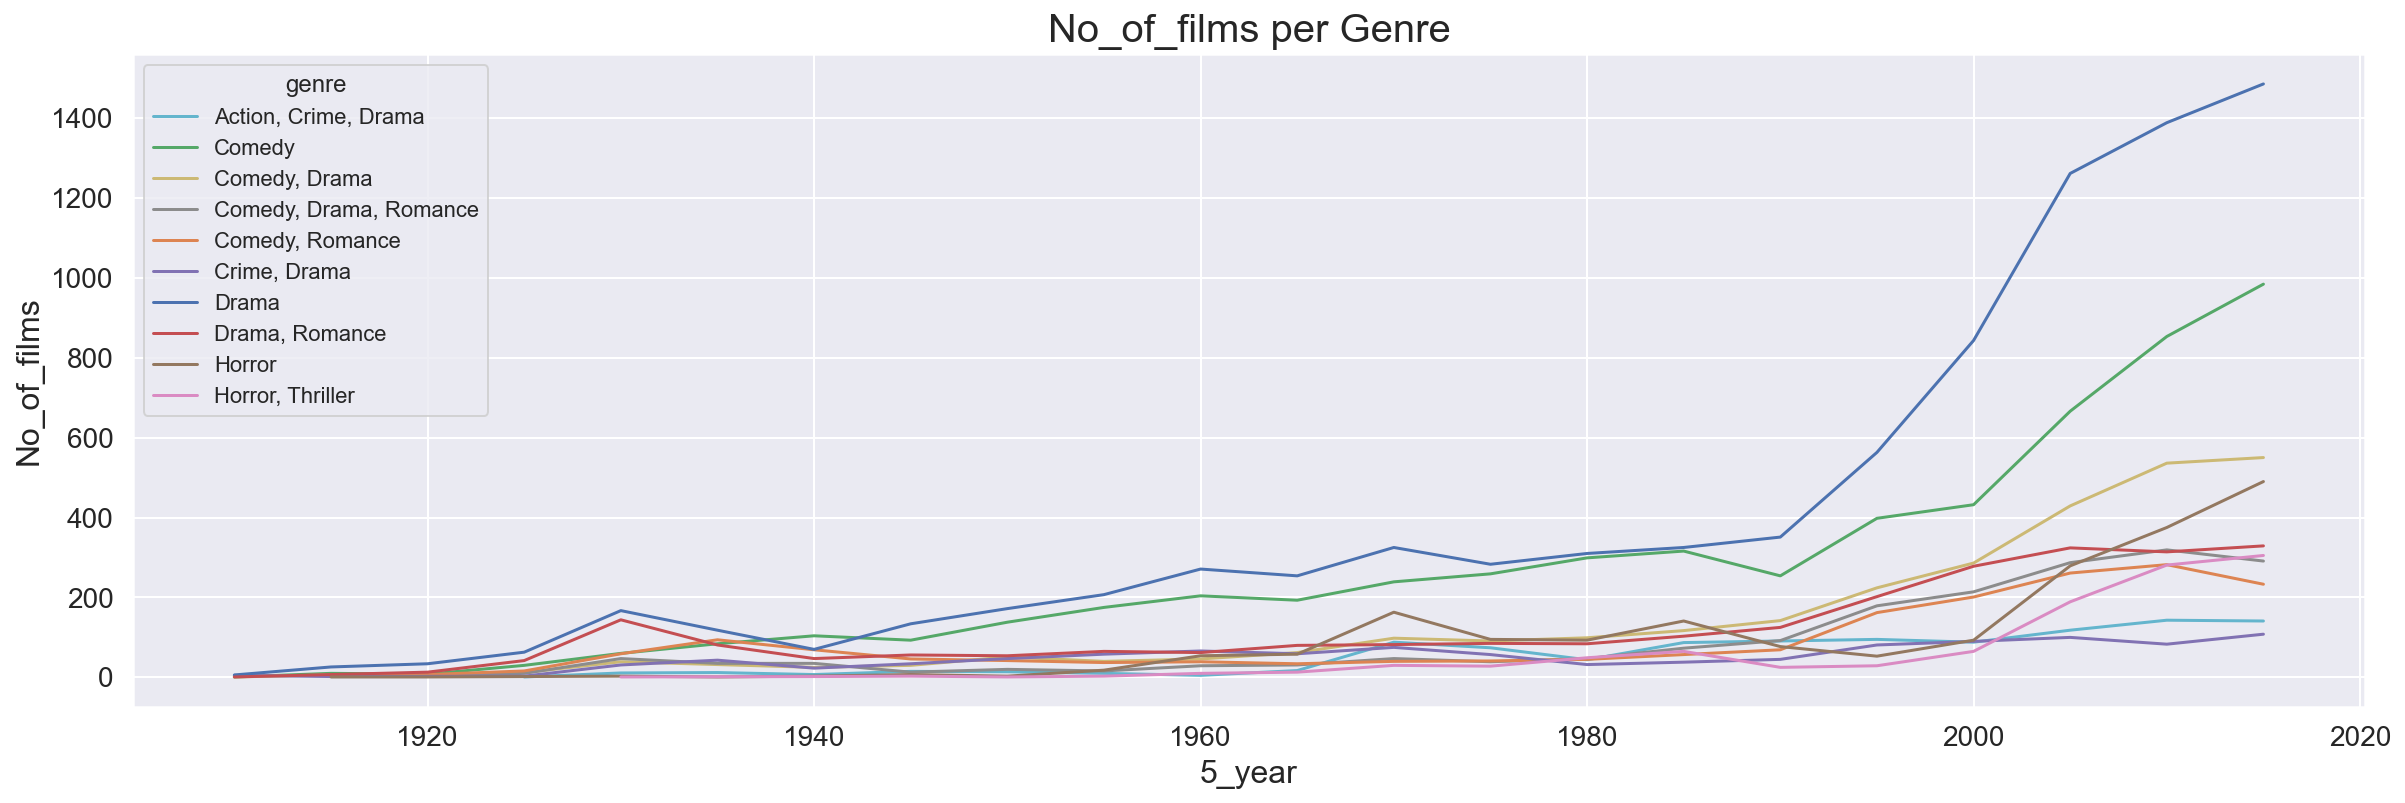

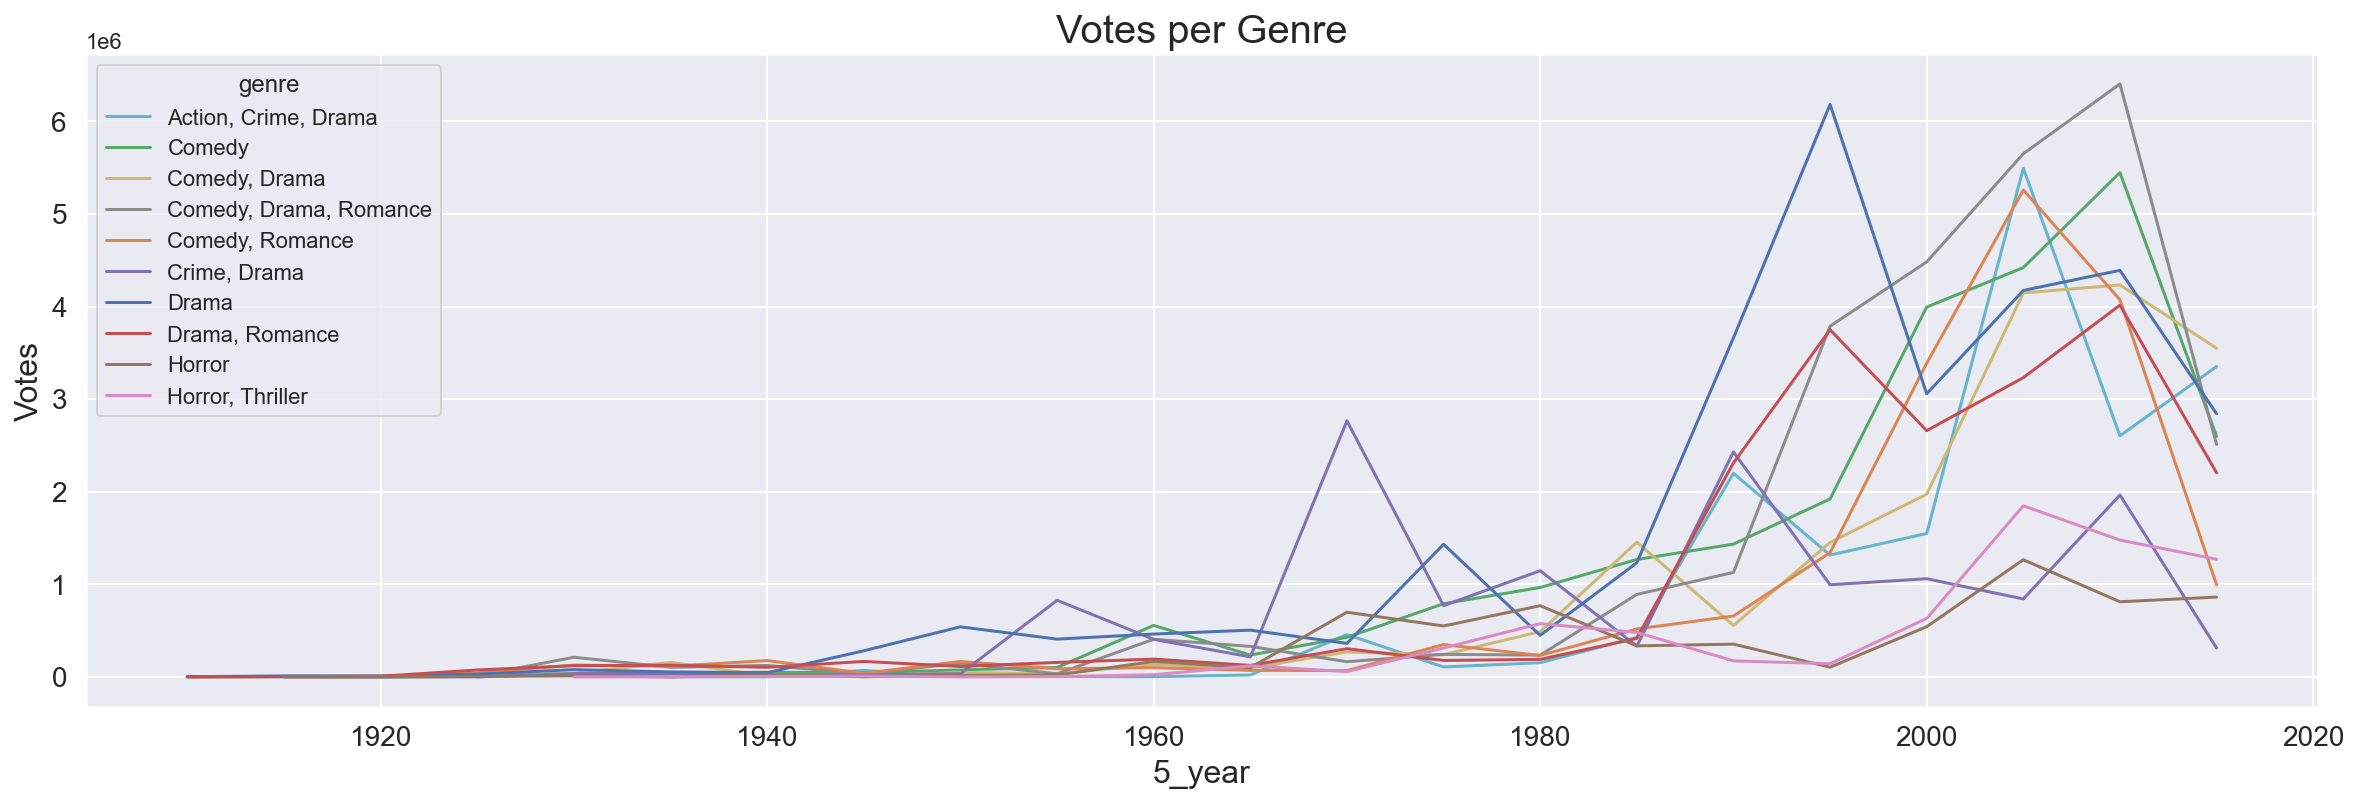

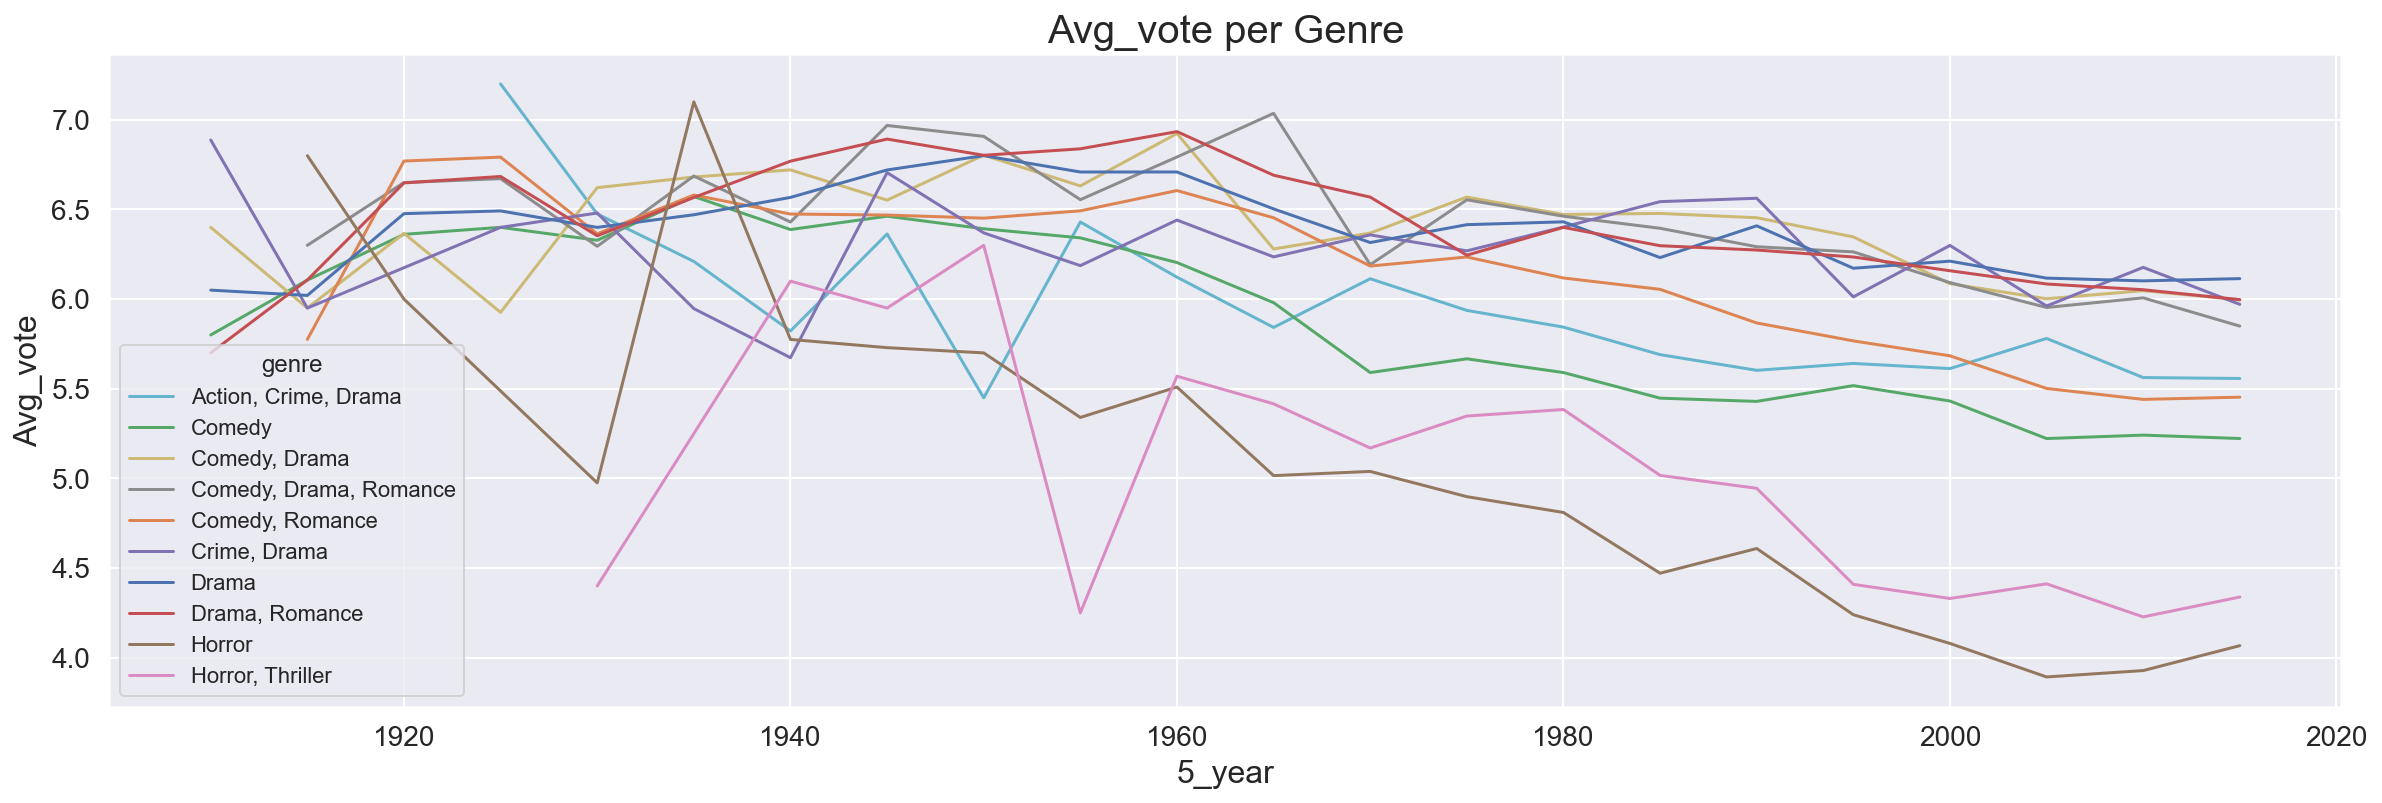

In [95]:
sns.set(rc={'figure.figsize':(20,6)})
def genre_graph(df,freq,metric):

    df = df.groupby(by=['genre',freq]).agg(no_of_films = ('no_of_films','sum'),
                                         avg_vote = ('avg_vote','mean'),
                                         votes = ('votes','sum')).reset_index()
    palette = {} 
    for i,j in enumerate(set(df.genre)):
        palette[j]='C'+str(i)
    sns.lineplot(y=df[metric],x=df[freq],hue=df['genre'],palette=palette)
    plt.title('{} per Genre'.format(metric.capitalize()),fontsize=20)
    plt.xlabel(xlabel=freq.capitalize(),fontsize=16)
    plt.ylabel(ylabel=metric.capitalize(),fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
genre_graph(df_gen,'5_year','no_of_films')
genre_graph(df_gen,'5_year','votes')
genre_graph(df_gen,'5_year','avg_vote')

Drama & Comedy has been the 2 most common genres since the early times. However, Romantic-Comedies got really popular since 1990s getting the highest amoung of total votes. Most genres cluster around average vote of 6 out of 10. Horror movies have got by far the lowes scores.

In [96]:
xx = df_movies.groupby(by=['language','genre']).agg(no_of_films = ('genre','count')).reset_index()
genre_lang_table = xx[(xx.language.isin(top_lang))].reset_index(drop=True)
genre_lang_table.sort_values(by=['language','no_of_films'],inplace=True,ascending=False)
genre_lang_table = top_genres(genre_lang_table,'language')
genre_lang_table

Turkish                 Spanish                 Russian  \
0                   Drama                   Drama                   Drama   
1                  Comedy                  Comedy                  Comedy   
2           Comedy, Drama           Comedy, Drama          Drama, Romance   
3          Drama, Romance          Drama, Romance           Comedy, Drama   
4         Comedy, Romance         Comedy, Romance              Drama, War   
5                  Horror                  Horror         Comedy, Romance   
6  Comedy, Drama, Romance         Drama, Thriller  Comedy, Drama, Romance   
7                 Romance  Comedy, Drama, Romance            Crime, Drama   
8        Horror, Thriller                Thriller          Drama, History   
9         Drama, Thriller  Crime, Drama, Thriller     Drama, History, War   

                   Mandarin                      Japanese  \
0                     Drama                         Drama   
1             Action, Drama  Animation, Action, Adventure   
2            Drama, Romance                Drama, Romance   
3                    Action                        Horror   
4           Comedy, Romance                        Comedy   
5                    Comedy                 Comedy, Drama   
6             Comedy, Drama      Action, Adventure, Drama   
7      Action, Crime, Drama                 Action, Drama   
8  Action, Adventure, Drama  Animation, Adventure, Comedy   
9    Comedy, Drama, Romance                 Action, Crime   

                     Italian                    Hindi                  German  \
0                     Comedy                    Drama                   Drama   
1                      Drama     Action, Crime, Drama                  Comedy   
2              Comedy, Drama           Drama, Romance           Comedy, Drama   
3                    Western   Comedy, Drama, Romance          Drama, Romance   
4             Drama, Romance            Comedy, Drama  Comedy, Drama, Romance   
5            Comedy, Romance            Action, Drama         Comedy, Romance   
6                     Horror                   Comedy            Crime, Drama   
7               Crime, Drama    Action, Comedy, Drama              Drama, War   
8     Comedy, Drama, Romance   Action, Drama, Romance         Drama, Thriller   
9  Horror, Mystery, Thriller  Drama, Musical, Romance                Thriller   

                   French                 English  
0                   Drama                   Drama  
1                  Comedy                  Comedy  
2           Comedy, Drama                  Horror  
3          Drama, Romance           Comedy, Drama  
4         Comedy, Romance          Drama, Romance  
5  Comedy, Drama, Romance  Comedy, Drama, Romance  
6            Crime, Drama         Comedy, Romance  
7         Drama, Thriller        Horror, Thriller  
8  Crime, Drama, Thriller                Thriller  
9           Comedy, Crime         Drama, Thriller

In [97]:
xx2 = xx[(xx.language.isin(top_lang)) & (xx.genre.isin(top10_genre))]
xx2 = xx2.pivot(index='genre',columns='language')
xx2.loc['total']=xx2.sum(axis=0)
xx2.columns = xx2.columns.droplevel(0) #drop index level no_of_films
xx2['total'] = xx2.sum(axis=1)
xx2 = xx2 / xx2.loc['total']
xx2 = xx2.drop(axis=0,labels='total')
xx2.sort_values(by='total',ascending=False,inplace=True)
genre_lang_ratios = xx2.copy()
genre_lang_ratios

language                 English    French    German     Hindi   Italian  \
genre                                                                      
Drama                   0.248735  0.372393  0.391712  0.230143  0.247530   
Comedy                  0.173652  0.251227  0.247850  0.079430  0.422257   
Comedy, Drama           0.095321  0.122699  0.111024  0.118126  0.092564   
Drama, Romance          0.089762  0.085890  0.077404  0.162933  0.049922   
Horror                  0.097570  0.011350  0.019547  0.015275  0.044202   
Comedy, Romance         0.073646  0.048773  0.051603  0.069246  0.044722   
Comedy, Drama, Romance  0.077332  0.048160  0.056294  0.125255  0.028081   
Horror, Thriller        0.059654  0.003988  0.008600  0.010183  0.011960   
Crime, Drama            0.040102  0.044785  0.032056  0.023422  0.041602   
Action, Crime, Drama    0.044225  0.010736  0.003909  0.165988  0.017161   

language                Japanese  Mandarin   Russian   Spanish   Turkish  \
genre                                                                      
Drama                   0.463598  0.397028  0.386272  0.419038  0.386997   
Comedy                  0.092050  0.084926  0.244953  0.205103  0.251806   
Comedy, Drama           0.087866  0.070064  0.078062  0.131992  0.095975   
Drama, Romance          0.111297  0.176221  0.100942  0.063297  0.088751   
Horror                  0.099582  0.031847  0.014805  0.049068  0.040248   
Comedy, Romance         0.019247  0.089172  0.067295  0.052012  0.061920   
Comedy, Drama, Romance  0.033473  0.048832  0.037685  0.032875  0.026832   
Horror, Thriller        0.011715  0.010616  0.017497  0.018155  0.018576   
Crime, Drama            0.041004  0.036093  0.034993  0.020608  0.014448   
Action, Crime, Drama    0.040167  0.055202  0.017497  0.007851  0.014448   

language                   total  
genre                             
Drama                   0.299837  
Comedy                  0.200908  
Comedy, Drama           0.101147  
Drama, Romance          0.089300  
Horror                  0.069556  
Comedy, Romance         0.063702  
Comedy, Drama, Romance  0.063321  
Horror, Thriller        0.038069  
Crime, Drama            0.037410  
Action, Crime, Drama    0.036752

In [98]:
xtick = genre_lang_ratios.columns.tolist()

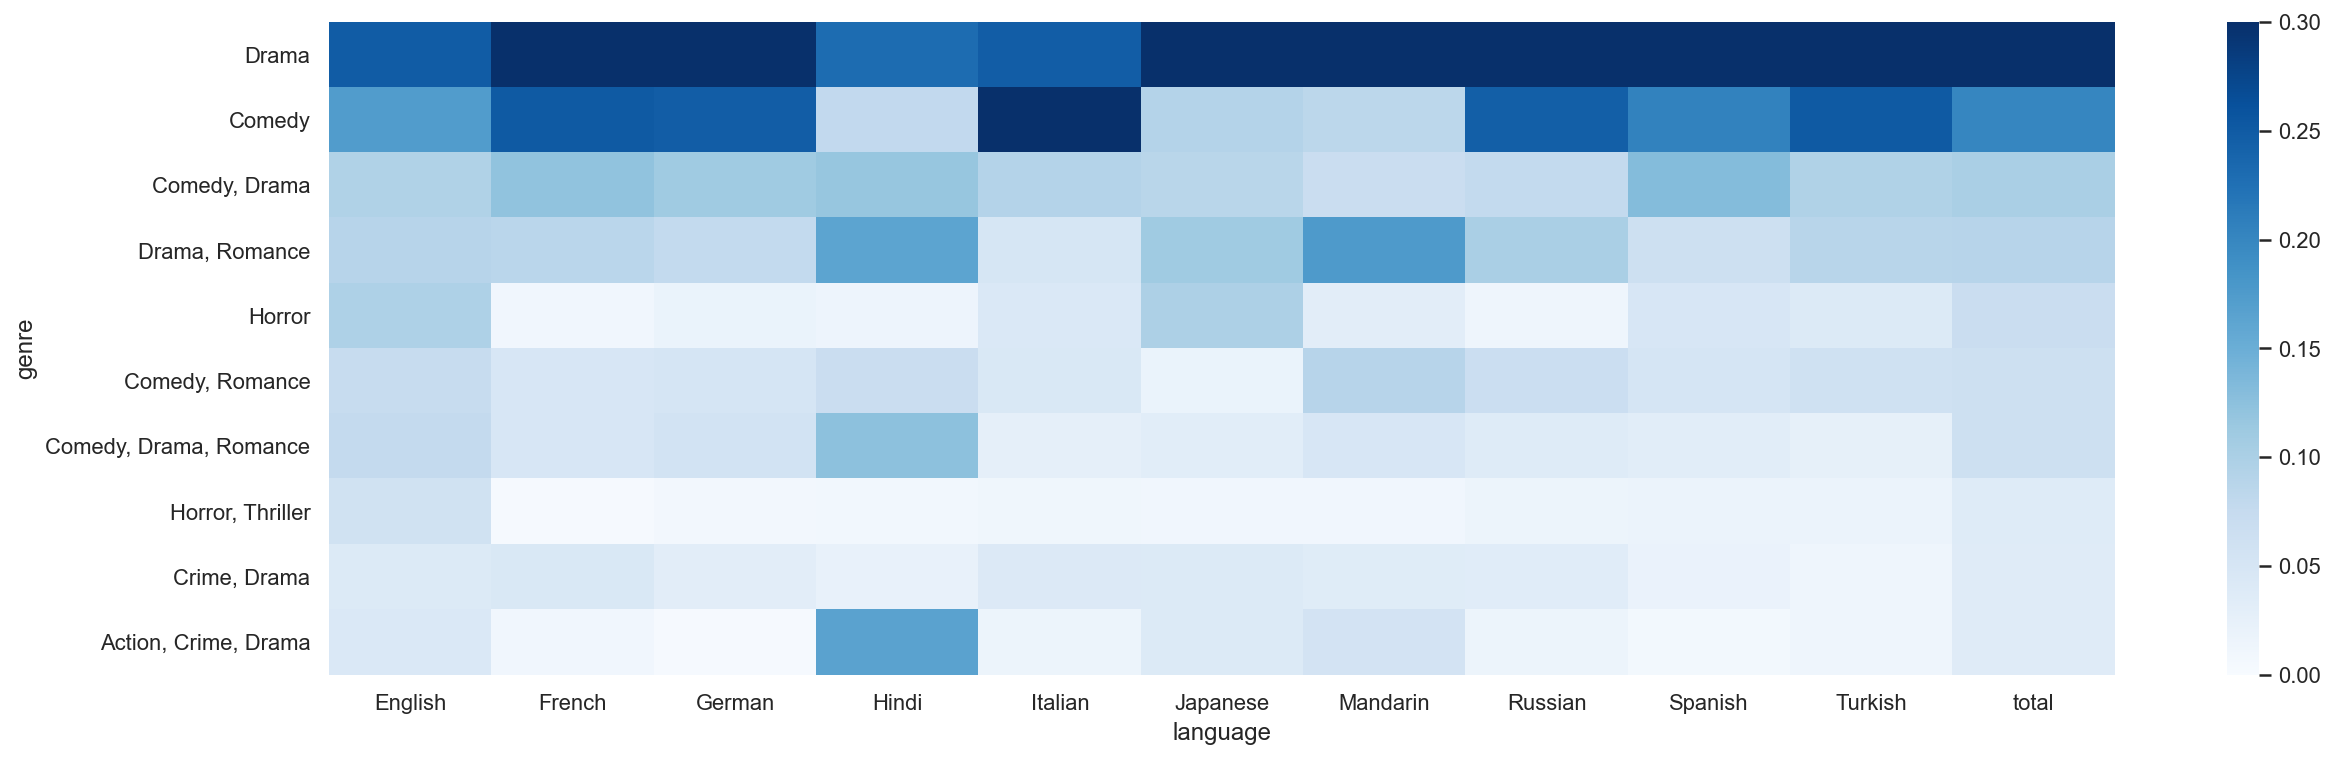

In [99]:
sns.heatmap(genre_lang_ratios,vmin=0,vmax=0.3,cmap='Blues',xticklabels=xtick)
plt.show()

In almost all languages, Drama is the main genre except for Italian. Hindi movies have frequently incorporated Action or Comedy features to their films. Another interesting fact is the higher share of horror films in Japanese films.

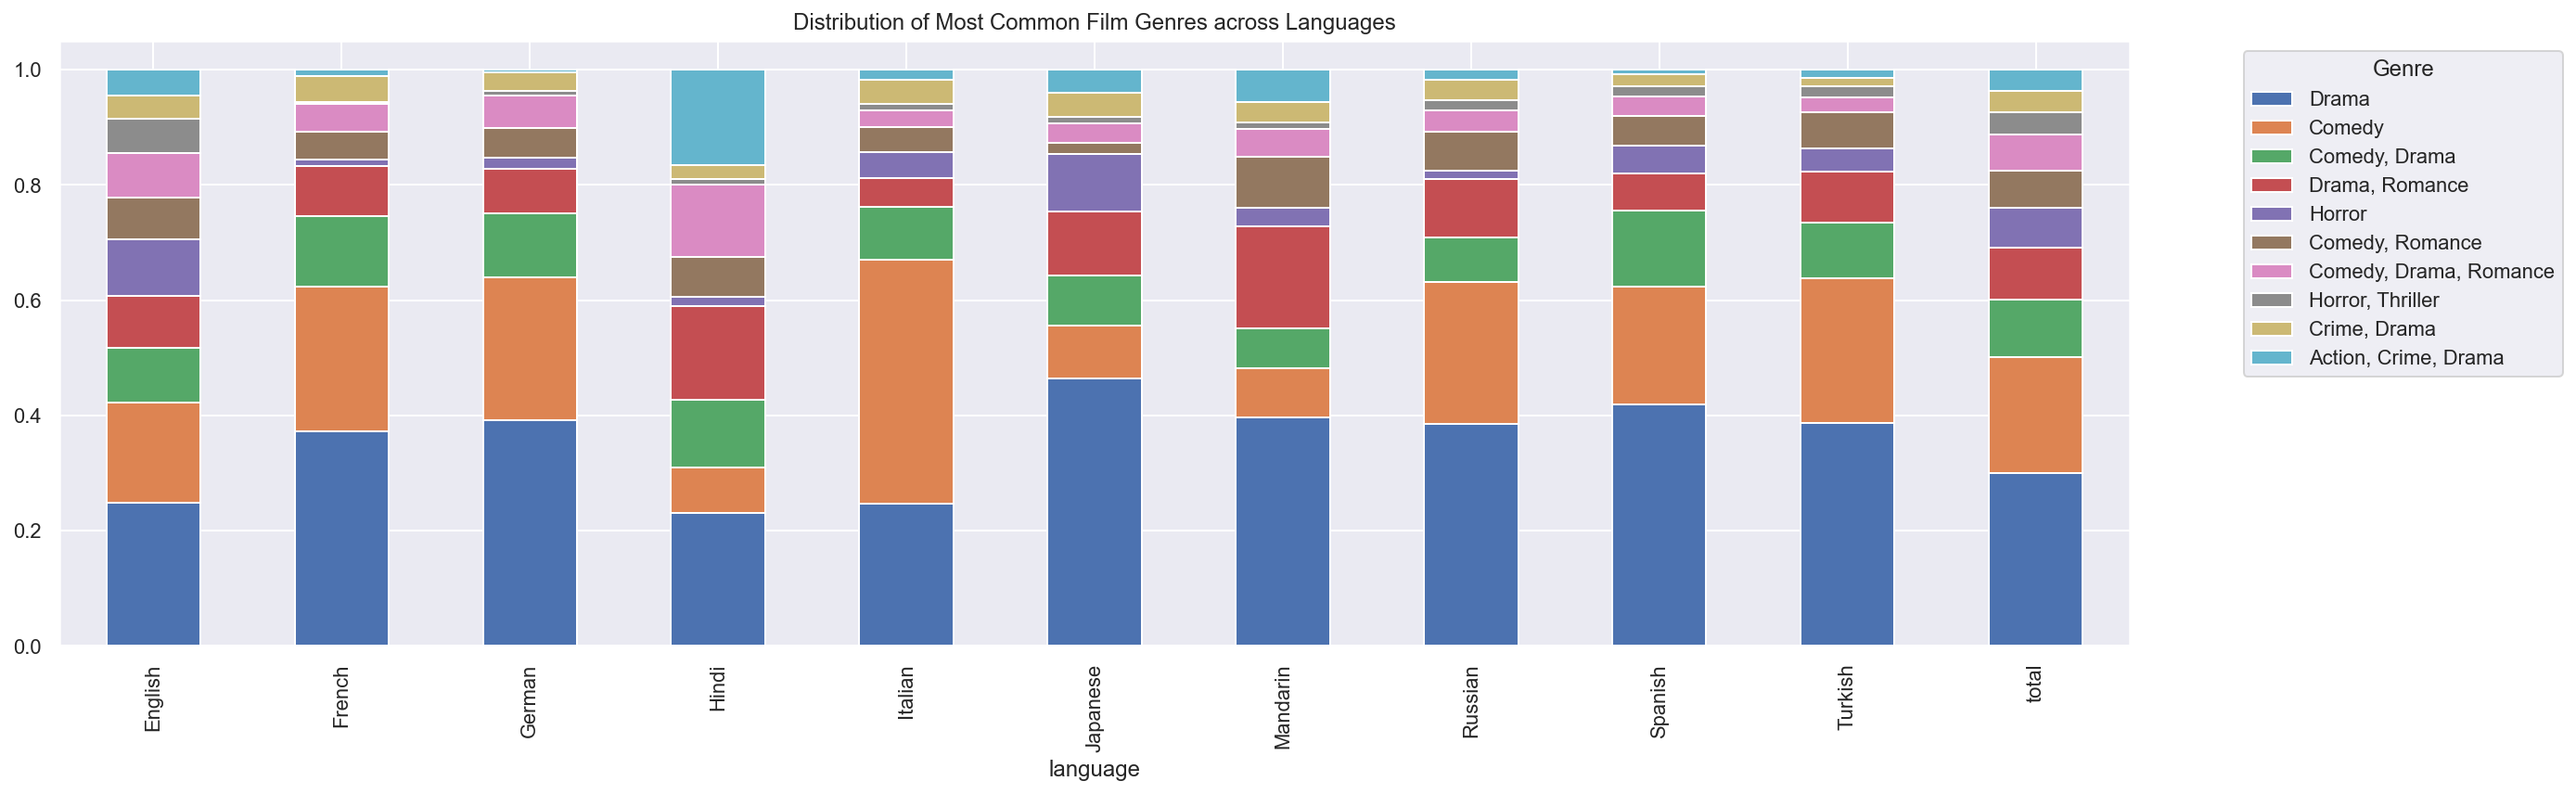

In [100]:
xx3 = xx2.transpose()
xx3.plot(kind='bar', stacked=True)
plt.title('Distribution of Most Common Film Genres across Languages')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1))
plt.show()

# Conclusion

# Limitations
The main challenge was data imbalance

Collecting more poster data for under-represented genres will not solve this issue

Subjective movie labelling by IMDb sources & varied posters for release

Limited packages to deal with multi-label classification problems iterative stratification for splitting data effectively, one-error loss etc.

## CNN model (not VGG16)
Hamming Loss score near of 0.7 indicates that for every 10 classifications, we only have 3 correct. So on average, 1 out of 3 movies are predicted rightly (assuming every movie has 3 genres)

Average Precision looks at the entire rankings predicted across the 23 genres. And having a score of close to 20% across 552 permutations of genres, proves to be rather encoruaging

Ranking Loss looks at how the expectation of the mis-rank rate over all possible pairs of labels, which had a mis-rank rate of 0.2 for possible pairs. Which is good, but has it's limitations since some movies 1 genre, or 3.
